# Context Veracity

Datset and Notebook to Scrape data from Politifiact

Politifact scraped data is saved in '**NEWS.csv**' file. The scraping is done in a **separate notebook**.

Link for scraped Dataset : https://drive.google.com/file/d/1w3lAOZn5rMvuaEkMcs_9g4FKVmop_Udd/view?usp=sharing

Fake news can take on many forms, including photoshopped images, fake user-generated content or spoofed accounts, network-based content designed to appeal to a particular organization or group, as well as knowledge-based stories that contain a scientific or reasonable explanation of unresolved issues, often resulting in the spread of false information.


The factor chosen for Fake news detection is Context veracity. The dataset used is scrapped data from Politifact. Along with scraping the news addtional source information for the news is also scrapped.
To determince context veracity we need to find evidence for the news topic.

##Data Narrative

Misinformation detection, which has become an increasingly important topic in Natural Language Processing. Misinformation refers to the distribution of false information in the context of news. 

For this Assignment the Liar Liar Plus dataset is used. The Liar Liar Plus dataset provides information about the source of a news and the score count for the source. For each source it determines the number of False / Ture counts.
This information was not included in the original Liar Liar dataset. Hence in the Liar Liar plus dataset further analysis of the source is included.

Along with this Politifact scrapped data is also used. For each news post Politifact proiveds source information which is  also scrapped to gather relaibility of the source.

##Import Libraries

In [1]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


##Import the Liar Liar Plus dataset

In [3]:
# Reading the tsv file into DataFrame


test_filename = '/content/drive/My Drive/Alternus_Vera/Veracity/test2.tsv'
train_filename = '/content/drive/My Drive/Alternus_Vera/Veracity/train2.tsv'
valid_filename = '/content/drive/My Drive/Alternus_Vera/Veracity/val2.tsv'

colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytruecounts','pantsonfirecounts','context', 'text']

train_news = pd.read_csv(train_filename, sep='\t', names = colnames, error_bad_lines=False)
test_news = pd.read_csv(test_filename, sep='\t', names = colnames, error_bad_lines=False)
valid_news = pd.read_csv(valid_filename, sep='\t', names = colnames, error_bad_lines=False)

In [4]:
train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text
0.0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1.0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2.0,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3.0,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4.0,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [5]:
# Dropping the 'id' column
train_news.drop('jsonid', axis = 1, inplace = True)
test_news.drop('jsonid', axis = 1, inplace = True)
valid_news.drop('jsonid', axis = 1, inplace = True)

In [6]:
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text
0.0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1.0,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3.0,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4.0,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [7]:
# Checking the shape of data
print(train_news.shape)
print(valid_news.shape)
print(test_news.shape)

(10242, 14)
(1284, 14)
(1267, 14)


#Data Cleaning and Text Preprocessing#

As a part of cleaning, we will perform below steps:
1. Remove Special characters
2. Convert text to lower case
3. Tokenization
4. Removing stop words
5. Lemmetization
6. Stemming

In [8]:
import re

def cleaning(raw_text):
    import nltk
    
    # 1. Remove non-letters/Special Characters
    text = re.sub("[^a-zA-Z]", " ", str(raw_text))
    
    # 2. Convert to lower case.
    text =  text.lower()
    
    # 3. Tokenize.
    text_words = nltk.word_tokenize(text)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  text_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [9]:
import time
import nltk
nltk.download('punkt')
nltk.download('wordnet')
# clean training and test data 
# create new column "tokenized"
t1 = time.time()

# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
train_news['clean_text'] = train_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem train data: \n", len(train_news), "news:", (t2-t1)/60, "min")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.

Time to clean, tokenize and stem train data: 
 10242 news: 0.13596401611963907 min


#Data Visualization#

In [10]:
# Final data present in datset after data preprocessing, and cleaning
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,clean_text
0.0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,say anni list polit group support third trimes...
1.0,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",declin coal start start natur gas took start b...
2.0,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,hillari clinton agre john mccain vote give geo...
3.0,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,health care reform legisl like mandat free sex...
4.0,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",econom turnaround start end term


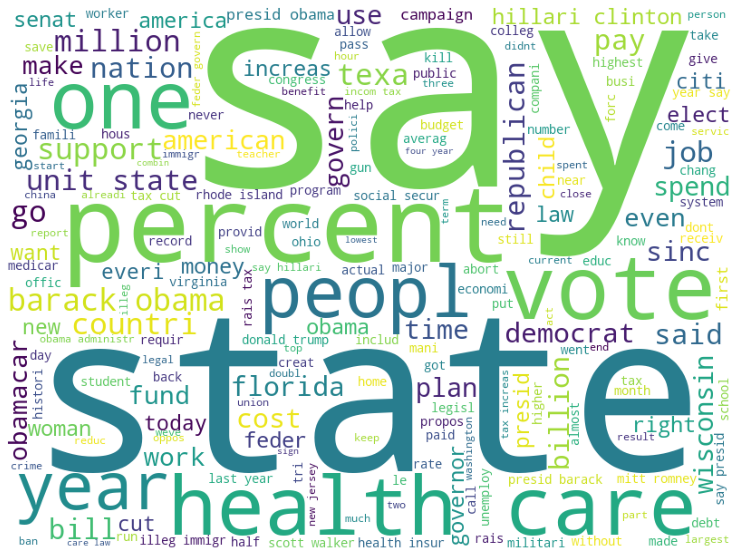

In [11]:
#Word cloud of Train dataset

from wordcloud import WordCloud, STOPWORDS
def wcloud(data,backgroundcolor = 'white', width = 800, height = 600):
    word_cloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
wcloud(' '.join(train_news['clean_text']))


#Verify Veracity 

###Convert Label to Binary values

In [12]:
train_news['label'] = train_news['label'].astype('category')
# Assigning numerical values and storing in another column
train_news['Label_cat'] = train_news['label'].cat.codes


In [13]:
train_news['Label_cat']

0.0        1
1.0        2
2.0        3
3.0        1
4.0        2
          ..
10264.0    3
10265.0    3
10266.0    2
10267.0    1
10268.0    4
Name: Label_cat, Length: 10242, dtype: int8

In [14]:
cat_to_nums = {"label":     {"true":1, "false":0, "barely-true": 0, "half-true": 0, "mostly-true": 1,"pants-fire": 0} }
train_news.replace(cat_to_nums, inplace=True)
train_news['label']


0.0        0.0
1.0        0.0
2.0        1.0
3.0        0.0
4.0        0.0
          ... 
10264.0    1.0
10265.0    1.0
10266.0    0.0
10267.0    0.0
10268.0    0.0
Name: label, Length: 10242, dtype: float64

In [15]:
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,clean_text,Label_cat
0.0,0.0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,say anni list polit group support third trimes...,1
1.0,0.0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",declin coal start start natur gas took start b...,2
2.0,1.0,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,hillari clinton agre john mccain vote give geo...,3
3.0,0.0,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,health care reform legisl like mandat free sex...,1
4.0,0.0,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",econom turnaround start end term,2


In [16]:
train_news['veracity'] = 0

In [17]:
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,clean_text,Label_cat,veracity
0.0,0.0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,say anni list polit group support third trimes...,1,0
1.0,0.0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",declin coal start start natur gas took start b...,2,0
2.0,1.0,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,hillari clinton agre john mccain vote give geo...,3,0
3.0,0.0,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,health care reform legisl like mandat free sex...,1,0
4.0,0.0,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",econom turnaround start end term,2,0


## Calculate the precision and accuracy and determine the veracity

In [18]:
falseNegative = 0
falsePositive = 0

trueNegative = 0
truePositive = 0


for index, row in train_news.iterrows():
    if (row.label == 0.0):
        if ((row.barelytruecounts < 4) | (row.falsecounts > 2) | (row.pantsonfirecounts > 1)):
            trueNegative += 1
            train_news.loc[index,'veracity'] = 1
        else:
            falseNegative += 1
            train_news.loc[index,'veracity'] = 0
    elif (row.label == 1.0):
        if ((row.halftruecounts > 4) | (row.mostlytruecounts > 4)):
            truePositive += 1
            train_news.loc[index,'veracity'] = 1
        else:
            falsePositive += 1
            train_news.loc[index,'veracity'] = 0
    

print("trueNegative=", trueNegative)
print("falseNegative=", falseNegative)
print("truePositive=", truePositive)
print("falsePositive=", falsePositive)


trueNegative= 6525
falseNegative= 77
truePositive= 1614
falsePositive= 2024


In [19]:
train_news[train_news['veracity'] == 1]

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,clean_text,Label_cat,veracity
0.0,0.0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,say anni list polit group support third trimes...,1,1
1.0,0.0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",declin coal start start natur gas took start b...,2,1
2.0,1.0,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,hillari clinton agre john mccain vote give geo...,3,1
3.0,0.0,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...,health care reform legisl like mandat free sex...,1,1
4.0,0.0,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start...",econom turnaround start end term,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10262.0,0.0,Mayor Fung wants to punish our childrens educa...,"children,city-budget,deficit,education,state-b...",richard-tomlins,NaN,Rhode Island,democrat,0.0,0.0,0.0,0.0,1.0,a recorded telephone message to Cranston resid...,"Marston said that in Texas, ""we lead the natio...",mayor fung want punish children educ remov mil...,4,1
10263.0,0.0,"Under the ruling of the Supreme Court, any lob...","corporations,elections",david-axelrod,NaN,NaN,democrat,2.0,1.0,6.0,7.0,0.0,an interview on ABC's This Week,"Deputy Secretary of State Kevin Tyne said, ""We...",rule suprem court lobbyist could go legisl say...,2,1
10266.0,0.0,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate,But that it leaves out important details and t...,say altern social secur oper galveston counti ...,2,1
10267.0,0.0,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...,"We checked the research and, quite frankly, fi...",lift u cuban embargo allow travel cuba,1,1


In [20]:
#Drop any Null values with no source information
train_news = train_news.dropna(how='any',axis=0) 

###Training the model on Liar Liar Plus data set

In [21]:
col_names = ['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytruecounts', 'pantsonfirecounts', 'veracity']
X = train_news[col_names]
Y = train_news['label']

In [22]:

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=.2)

###Logisitc Regression

In [23]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,Y_train)
predictions = logmodel.predict(X_test)

In [24]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85       841
         1.0       0.79      0.63      0.70       493

    accuracy                           0.80      1334
   macro avg       0.80      0.77      0.78      1334
weighted avg       0.80      0.80      0.79      1334



###Naive Bayes Classifier

Using Naive Bayes Classifier

In [25]:
from sklearn.naive_bayes import GaussianNB

In [26]:
model = GaussianNB()

In [27]:
model.fit(X_train,Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [28]:
pred = model.predict(X_test)

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n")
print(confusion_matrix(Y_test,pred))
print("Classification Report:\n")
print(classification_report(Y_test,pred))
print('Accuracy score for Naive Bayes:\n', accuracy_score(Y_test, pred))


Confusion Matrix: 

[[786  55]
 [211 282]]
Classification Report:

              precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       841
         1.0       0.84      0.57      0.68       493

    accuracy                           0.80      1334
   macro avg       0.81      0.75      0.77      1334
weighted avg       0.81      0.80      0.79      1334

Accuracy score for Naive Bayes:
 0.800599700149925


In [30]:
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,text,clean_text,Label_cat,veracity
0.0,0.0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,say anni list polit group support third trimes...,1,1
1.0,0.0,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",declin coal start start natur gas took start b...,2,1
2.0,1.0,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...,hillari clinton agre john mccain vote give geo...,3,1
5.0,1.0,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,"But Vos specifically used the word ""fired,"" wh...",chicago bear start quarterback last year total...,5,1
7.0,0.0,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.","However, it was not that bill, but another one...",person stage work activ last year pass along r...,2,1


In [31]:
train_news.drop(['subject', 'speakerjobtitle', 'stateinfo', 'partyaffiliation', 'context', 'text'], axis=1, inplace=True)

In [32]:
train_news.head()

,label,headline_text,speaker,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,clean_text,Label_cat,veracity
0.0,0.0,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,say anni list polit group support third trimes...,1,1
1.0,0.0,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,declin coal start start natur gas took start b...,2,1
2.0,1.0,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,hillari clinton agre john mccain vote give geo...,3,1
5.0,1.0,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,chicago bear start quarterback last year total...,5,1
7.0,0.0,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,person stage work activ last year pass along r...,2,1


In [33]:
train_news.drop(['clean_text'], axis=1, inplace=True)

In [34]:
train_news = train_news.rename(columns={'headline_text': 'title', 'speaker': 'Source', 'label': 'Label'})

In [35]:
train_news.head()

,Label,title,Source,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,Label_cat,veracity
0.0,0.0,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,1,1
1.0,0.0,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,2,1
2.0,1.0,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,3,1
5.0,1.0,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,5,1
7.0,0.0,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,2,1


Combine the counts of the author to determine the average source count

In [36]:
 col_to_avg = ['barelytruecounts', 'falsecounts', 'pantsonfirecounts', 'halftruecounts', 'mostlytruecounts']
train_news['title_count'] = train_news[col_to_avg].mean(axis=1)


In [37]:
train_news.head()

,Label,title,Source,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,Label_cat,veracity,title_count
0.0,0.0,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,1,1,0.2
1.0,0.0,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,2,1,0.4
2.0,1.0,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,3,1,94.6
5.0,1.0,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,5,1,2.2
7.0,0.0,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,2,1,94.6


Round of the float value

In [77]:
train_news['title_count'] = train_news['title_count'].astype(int)
train_news['Label'] = train_news['Label'].astype(int)

In [78]:
train_news.head()

,Label,title,Source,Label_cat,veracity,title_count
0.0,0,Says the Annies List political group supports ...,dwayne-bohac,1,1,0
1.0,0,When did the decline of coal start? It started...,scott-surovell,2,1,0
2.0,1,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,3,1,94
5.0,1,The Chicago Bears have had more starting quart...,robin-vos,5,1,2
7.0,0,I'm the only person on this stage who has work...,barack-obama,2,1,94


In [40]:
col_to_drop = ['barelytruecounts', 'falsecounts', 'pantsonfirecounts', 'halftruecounts', 'mostlytruecounts']
train_news.drop(col_to_drop, axis=1, inplace=True)

In [41]:
train_news.head()

,Label,title,Source,Label_cat,veracity,title_count
0.0,0.0,Says the Annies List political group supports ...,dwayne-bohac,1,1,0
1.0,0.0,When did the decline of coal start? It started...,scott-surovell,2,1,0
2.0,1.0,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,3,1,94
5.0,1.0,The Chicago Bears have had more starting quart...,robin-vos,5,1,2
7.0,0.0,I'm the only person on this stage who has work...,barack-obama,2,1,94


In [42]:
#Break point
#import pdb; pdb.set_trace()

##Data Amalgamation

Amalagamate the scraped data from Politifact.

The politifact dataset is source of the latest political news with their resources. Here the Politifact dataset is imported which was scraped earlier and further 

In [89]:
df_posts = pd.read_csv('/content/drive/My Drive/Alternus_Vera/Veracity/Veracity_main.csv', sep=',', error_bad_lines=False)

In [90]:
df_posts.head()

,Unnamed: 0,title,title_count,veracity,Link,Date,Source,Label
0,0,A “system glitch” in Wisconsin that “swapped v...,4.0,0,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Eric Trump,false
1,1,More mail-in ballots were counted in Lancaster...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 5, 2020",Viral image,false
2,2,"Kamala Harris’ husband said, “I am married to ...",2.0,0,https://www.politifact.com/factchecks/2020/oct...,"ober 22, 2020",Facebook posts,barely-true
3,3,“Wisconsin has more votes than people who are ...,2.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 4, 2020",Tweets,pants-fire
4,4,“The NAACP has received credible information t...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 7, 2020",Facebook posts,false


In [91]:
#df_posts = df_posts.drop(df_posts.columns[[0]], axis=1)

In [92]:
df_posts = df_posts.rename(columns={'Statement': 'title'})

In [93]:
df_posts.head()

,title,title_count,veracity,Link,Date,Source,Label
0,A “system glitch” in Wisconsin that “swapped v...,4.0,0,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Eric Trump,false
1,More mail-in ballots were counted in Lancaster...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 5, 2020",Viral image,false
2,"Kamala Harris’ husband said, “I am married to ...",2.0,0,https://www.politifact.com/factchecks/2020/oct...,"ober 22, 2020",Facebook posts,barely-true
3,“Wisconsin has more votes than people who are ...,2.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 4, 2020",Tweets,pants-fire
4,“The NAACP has received credible information t...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 7, 2020",Facebook posts,false


In [94]:
df_posts.drop(['Link', 'Date'], axis=1, inplace=True)

In [95]:
df_posts['title_count'] = df_posts['title_count'].astype(int)

In [96]:
df_posts.head()

,title,title_count,veracity,Source,Label
0,A “system glitch” in Wisconsin that “swapped v...,4,0,Eric Trump,false
1,More mail-in ballots were counted in Lancaster...,1,0,Viral image,false
2,"Kamala Harris’ husband said, “I am married to ...",2,0,Facebook posts,barely-true
3,“Wisconsin has more votes than people who are ...,2,0,Tweets,pants-fire
4,“The NAACP has received credible information t...,1,0,Facebook posts,false


In [97]:
df_posts['Label']

0            false
1            false
2      barely-true
3       pants-fire
4            false
          ...     
123          false
124          false
125          false
126      half-true
127     pants-fire
Name: Label, Length: 128, dtype: object

###Convert Label to Binary values

In [98]:
df_posts['Label'] = df_posts['Label'].astype('category')
# Assigning numerical values and storing in another column
df_posts['Label_cat'] = df_posts['Label'].cat.codes


In [99]:
df_posts['Label_cat']

0      1
1      1
2      0
3      5
4      1
      ..
123    1
124    1
125    1
126    3
127    5
Name: Label_cat, Length: 128, dtype: int8

In [100]:
cat_to_nums = {'Label':     {'true':1, 'false':0, 'barely-true': 0, 'half-true': 0, 'mostly-true': 1,'pants-fire': 0, 'full-flop': 0} }
df_posts.replace(cat_to_nums, inplace=True)
df_posts['Label']


0      0
1      0
2      0
3      0
4      0
      ..
123    0
124    0
125    0
126    0
127    0
Name: Label, Length: 128, dtype: int64

In [101]:
df_posts.head()

,title,title_count,veracity,Source,Label,Label_cat
0,A “system glitch” in Wisconsin that “swapped v...,4,0,Eric Trump,0,1
1,More mail-in ballots were counted in Lancaster...,1,0,Viral image,0,1
2,"Kamala Harris’ husband said, “I am married to ...",2,0,Facebook posts,0,0
3,“Wisconsin has more votes than people who are ...,2,0,Tweets,0,5
4,“The NAACP has received credible information t...,1,0,Facebook posts,0,1


###Combine Datasets

Here both the datasets are combined

In [102]:
df_main = train_news.append(df_posts)

In [103]:
df_main.shape

(6797, 6)

In [104]:
df_main['Label'].unique()

array([0, 1])

In [105]:
df_main

,Label,title,Source,Label_cat,veracity,title_count
0.0,0,Says the Annies List political group supports ...,dwayne-bohac,1,1,0
1.0,0,When did the decline of coal start? It started...,scott-surovell,2,1,0
2.0,1,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,3,1,94
5.0,1,The Chicago Bears have had more starting quart...,robin-vos,5,1,2
7.0,0,I'm the only person on this stage who has work...,barack-obama,2,1,94
...,...,...,...,...,...,...
123.0,0,Says Joe Biden said “Why am I doing this? Why?...,Donald Trump,1,1,4
124.0,0,Says Joe Biden repeatedly told Americans he's ...,Donald Trump,1,1,20
125.0,0,Says Joe Biden received a sudden influx of 138...,Tweets,1,1,5
126.0,0,Says Donald Trump “is pushing to slash Medicar...,Joe Biden,3,1,18


In [106]:
df_main.shape

(6797, 6)

##Data Visualization of *New* dataset

##Comparing Accuracy

Here we calculate the accuracy after combining both dataset.

To determine the authenticity of a source not only the source information but the entire text of the source with other reliable resources need to be considered.

Hence the dataset from Politifact and the Liar Liar dataset are merged together and further checking the accuracy of the two datasets combined.

In [108]:
col_names1 = ['veracity', 'title_count']
X1 = df_main[col_names1]
Y1 = df_main['Label']

In [109]:

X1_train, X1_test, Y1_train, Y1_test = \
    train_test_split(X1, Y1, test_size=.2)

In [110]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=100000)
logmodel.fit(X1_train,Y1_train)
predictions = logmodel.predict(X1_test)

In [111]:
from sklearn.metrics import classification_report
print(classification_report(Y1_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       861
           1       0.80      0.59      0.68       499

    accuracy                           0.80      1360
   macro avg       0.80      0.75      0.77      1360
weighted avg       0.80      0.80      0.79      1360



##Naive Bayes

Using Naive Bayes Classifier

In [112]:
from sklearn.naive_bayes import GaussianNB

In [113]:
model = GaussianNB()

In [114]:
model.fit(X1_train,Y1_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [115]:
pred = model.predict(X1_test)

In [116]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n")
print(confusion_matrix(Y1_test,pred))
print("Classification Report:\n")
print(classification_report(Y1_test,pred))
print('Accuracy score for Naive Bayes:\n', accuracy_score(Y1_test, pred))


Confusion Matrix: 

[[840  21]
 [254 245]]
Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       861
           1       0.92      0.49      0.64       499

    accuracy                           0.80      1360
   macro avg       0.84      0.73      0.75      1360
weighted avg       0.82      0.80      0.78      1360

Accuracy score for Naive Bayes:
 0.7977941176470589


##Random Classifier

In [118]:
# Create Random Forest classifer object
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train Random Forest Classifer
clf = clf.fit(X1_train,Y1_train)

#Predict the response for test dataset
Y1_pred = clf.predict(X1_test)

In [120]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(Y1_test, Y1_pred))

Accuracy: 0.7985294117647059


### Gini score

In [122]:
import pandas as pd
col_names = ['veracity', 'title_count']
pima = df_main[col_names]
feature_imp = pd.Series(clf.feature_importances_,pima.columns).sort_values(ascending=False)
feature_imp

veracity       0.716457
title_count    0.283543
dtype: float64

No handles with labels found to put in legend.


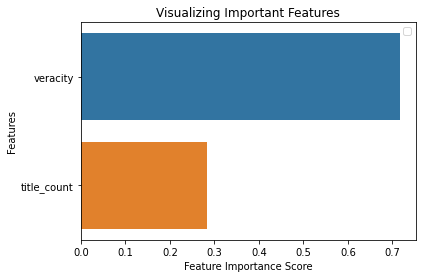

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

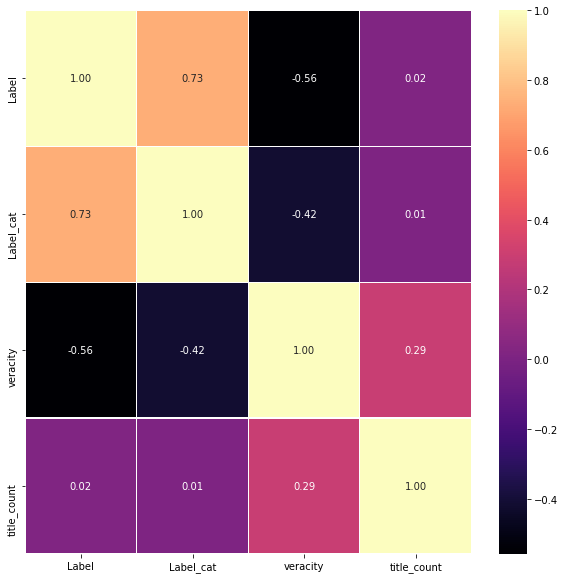

In [124]:
fig,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_main.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

# Machine Learning Algorithm


In [125]:
#Import Libraries
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [127]:
col_names2 = ['veracity', 'title_count']
X_data_reshape = df_main[col_names2] # Features
y_data = df_main.Label # Target variable

Split the data into Training set and Test data

### Different Classifiers

In [128]:
from time import time
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


Create Train and Test data

In [129]:
X, y = X_data_reshape, y_data

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)


### Muller Loop

Apply different classifiers to get the test scores and accuracy

# Accuracy Comparison

In [145]:
# TODO (Apply): All cross-validation

max_score = 0.0
max_class = ''
# iterate over classifiers
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
print(color.BOLD + color.BLUE + '########### Classifier Comparison ############\n\n' + color.END)
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print(color.BOLD + color.PURPLE + 'Classifier = %s, Accuracy Score = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time) + color.END)
    print('\n')
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(color.BOLD + color.BLUE + '\n\n##############################################################' + color.END)
print('\n\n')
print(color.BOLD + color.BLUE + 80*'-' + color.END)
print('\n\n')
print(color.BOLD + color.GREEN + 'Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score) + color.END)
print('\n\n')
#plot the output of the various algorithms

########### Classifier Comparison ############


Classifier = Nearest Neighbors, Accuracy Score = 73.68, Training time = 0.09 seconds


Classifier = Linear SVM, Accuracy Score = 80.78, Training time = 0.63 seconds


Classifier = RBF SVM, Accuracy Score = 80.74, Training time = 3.03 seconds


Classifier = Gaussian Process, Accuracy Score = 80.34, Training time = 539.07 seconds


Classifier = Decision Tree, Accuracy Score = 80.59, Training time = 0.00 seconds


Classifier = Random Forest, Accuracy Score = 80.69, Training time = 0.04 seconds


Classifier = Neural Net, Accuracy Score = 80.78, Training time = 1.77 seconds


Classifier = AdaBoost, Accuracy Score = 80.78, Training time = 0.20 seconds


Classifier = Naive Bayes, Accuracy Score = 80.78, Training time = 0.00 seconds


Classifier = QDA, Accuracy Score = 80.78, Training time = 0.01 seconds




##############################################################



-------------------------------------------------------------------------

The test score and accuracy from different classifiers is shown above

### Comparison of Calibration of Classifiers

Import Libraries

In [146]:
# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

np.random.seed(0)

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.neural_network import MLPClassifier

Plot different classifiers

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


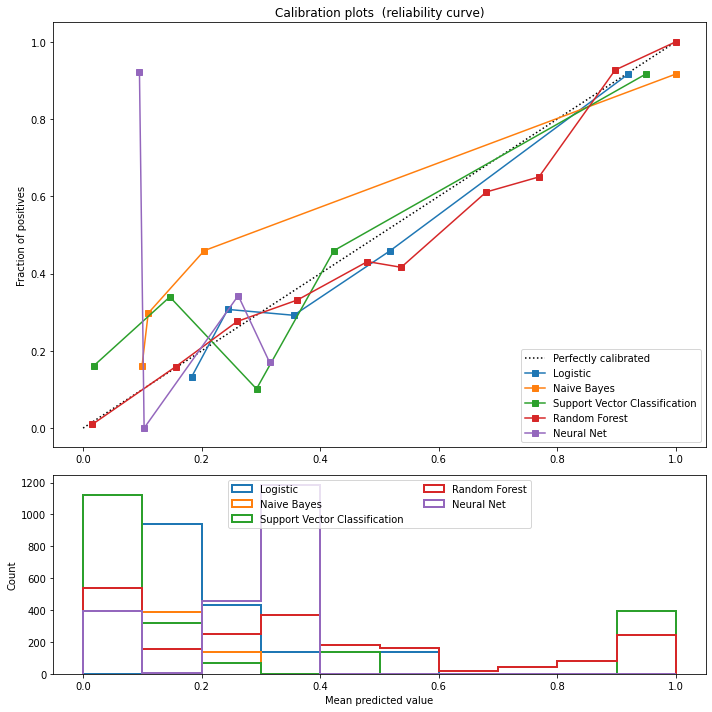

In [147]:
# Create classifiers
lr = LogisticRegression(solver='lbfgs')
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)
nn = MLPClassifier(hidden_layer_sizes=(15,), random_state=1, max_iter=1, warm_start=True)

# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                  (nn, 'Neural Net')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()


# Metrics for Measuring Model

## Confusion Matrix and Accuracy, Precision, Recall, F1, RMSE

In [148]:
!pip install -U yellowbrick
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

     |████████████████████████████████| 276kB 6.3MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


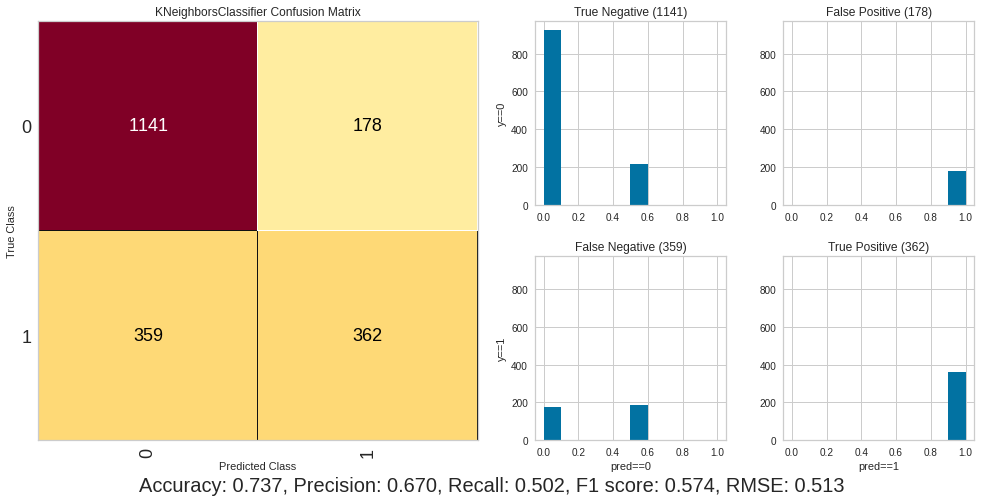

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


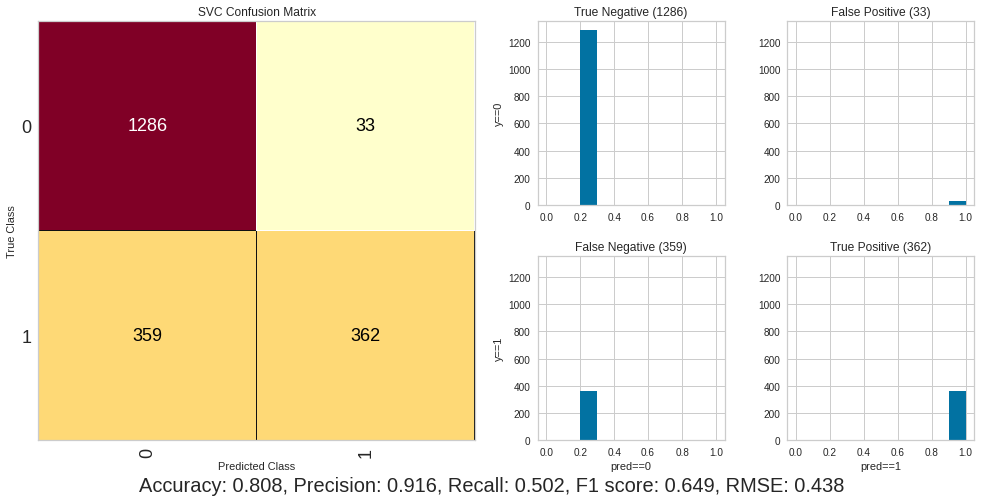

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


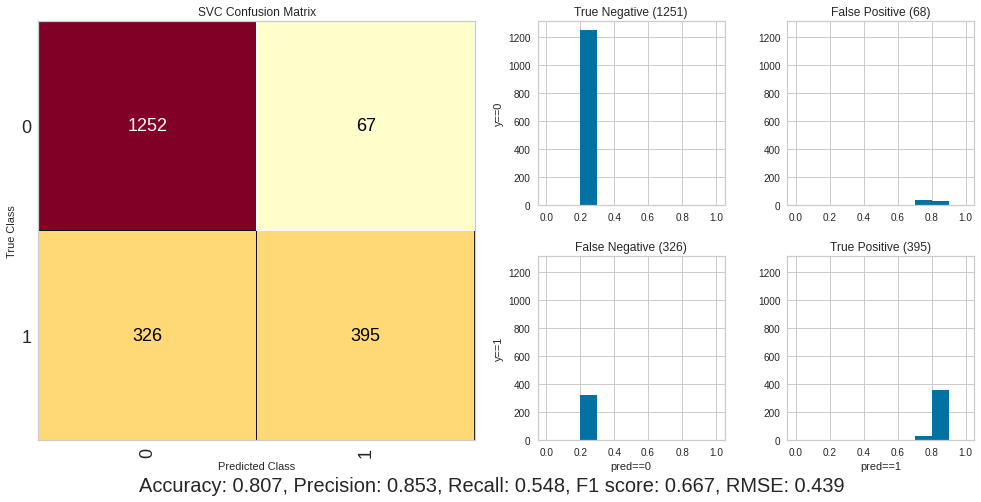

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


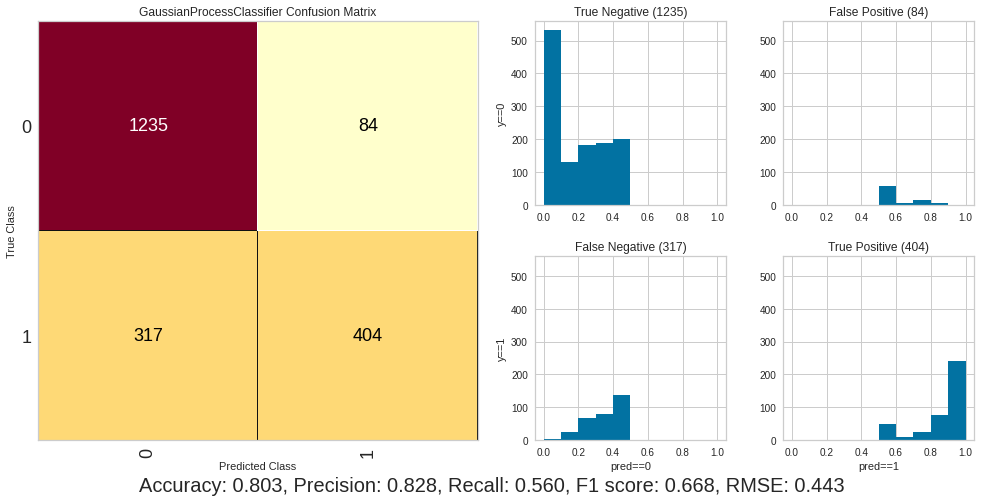

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


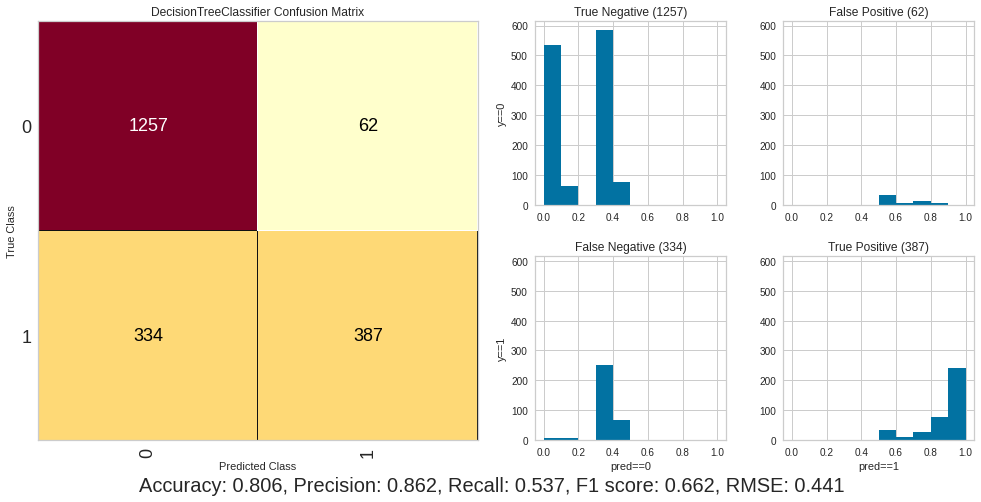

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


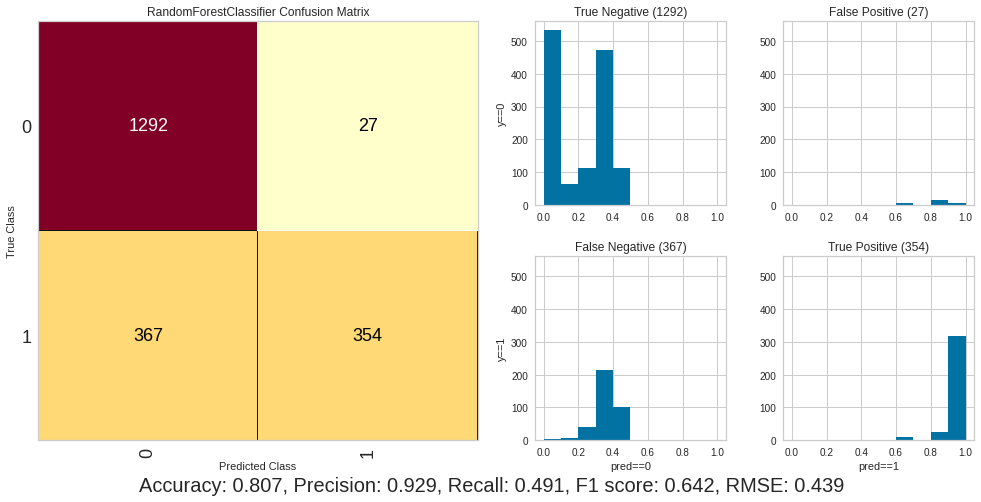

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


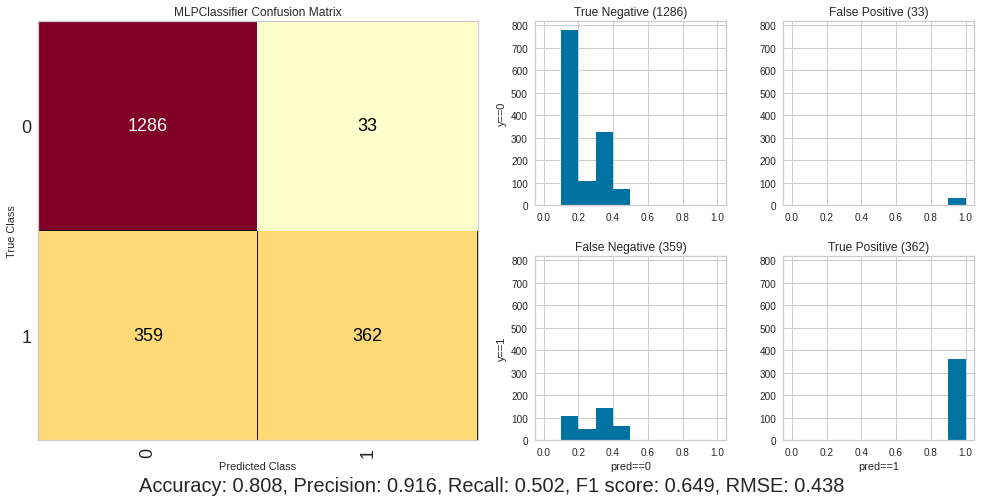

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


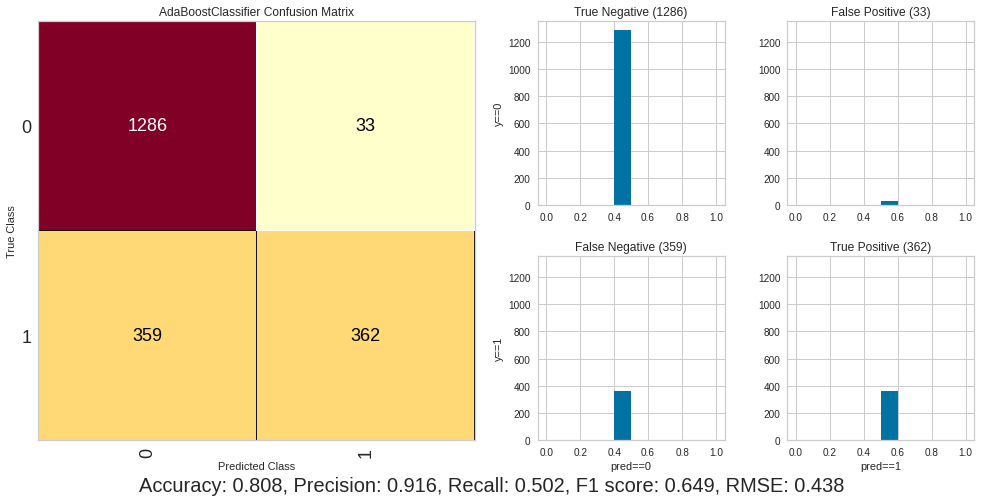

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


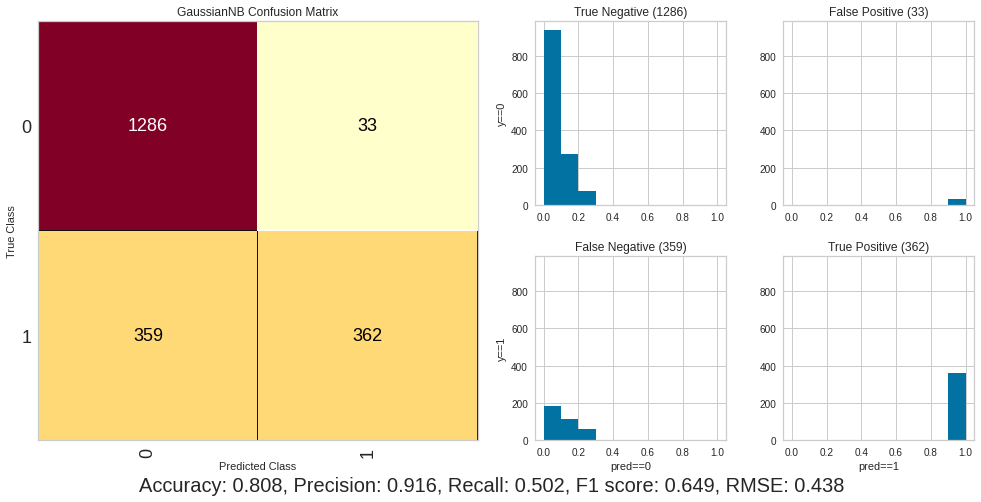

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


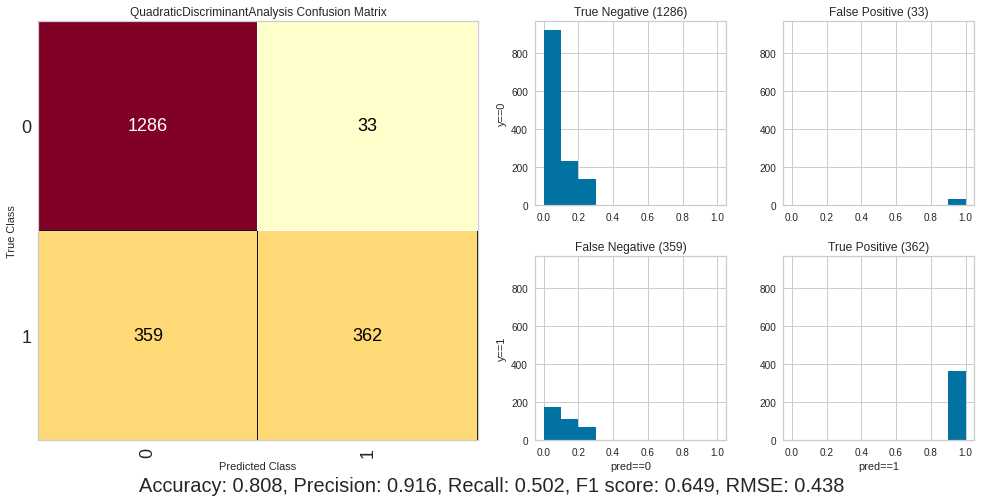

In [149]:
def show_quarter(df, query, col, title, ax, bins, x_label=None, y_label=None):
    results = df.query(query)
    results[col].hist(ax=ax, bins=bins); 
    if y_label:
        ax.set_ylabel(y_label)
    if x_label:
        ax.set_xlabel(x_label)
    ax.set_title(title + " ({})".format(results.shape[0])) #IANBOB
    return results.shape[0]

bins = np.arange(0, 1.01, 0.1)

for clf in classifiers:
    fig = plt.figure(figsize=(14, 7))
    ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
    ax2 = plt.subplot2grid((2, 4), (0, 2))
    ax3 = plt.subplot2grid((2, 4), (0, 3), sharex=ax2, sharey=ax2)
    ax4 = plt.subplot2grid((2, 4), (1, 2), sharex=ax2, sharey=ax2)
    ax5 = plt.subplot2grid((2, 4), (1, 3), sharex=ax2, sharey=ax2)

    cm = ConfusionMatrix(clf, classes=[0, 1], ax=ax1)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)

    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    df_predictions = pd.DataFrame({'y': y_test, 'y_proba': prob_pos})
    TN = show_quarter(df_predictions, "y==0 and y_proba <= 0.5", "y_proba", "True Negative", ax2, bins, y_label="y==0")
    FP = show_quarter(df_predictions, "y==0 and y_proba > 0.5", "y_proba", "False Positive", ax3, bins)
    TP = show_quarter(df_predictions, "y==1 and y_proba > 0.5", "y_proba", "True Positive", ax5, bins, x_label="pred==1")
    FN = show_quarter(df_predictions, "y==1 and y_proba <= 0.5", "y_proba", "False Negative", ax4, bins, x_label="pred==0", y_label="y==1")
    RMSE = mean_squared_error(y_test, clf.predict(X_test), squared=False)

    Acc = (TP+TN)/(TP+TN+FP+FN)
    Prec = TP/(TP+FP)
    Rec = TP/(TP+FN)
    F1 = 2*Prec*Rec/(Prec+Rec)

    txt = f'Accuracy: {Acc:.3f}, Precision: {Prec:.3f}, Recall: {Rec:.3f}, F1 score: {F1:.3f}, RMSE: {RMSE:.3f}'
    plt.figtext(0.5, 0, txt, wrap=True, horizontalalignment='center', fontsize=20)

    cm.show()

# Pickle models

In [155]:
import pickle
from zipfile import ZipFile
import os

In [156]:
with ZipFile('/content/drive/My Drive/Alternus_Vera/Veracity/models.zip', 'w') as myzip:
    for name, clf in zip(names, classifiers):
        pickle.dump(clf, open(f'{name}_model.pickle', 'wb'))
        myzip.write(f'{name}_model.pickle')
        os.remove(f'{name}_model.pickle')

# Conclusion

Reputation based source verification is not enough.

Only title text is analyzed in most cases not the entire story or article.

The so-called suspicious sources, however,
sometimes do publish facts and valid information, and reputable websites sometimes publish inaccu-rate information

Other websites such as Snopes / Buzz feed do not provide source information but rather post from FB in contrast to Politifact

## References

https://github.com/sfu-discourse-lab/MisInfoText
Github resource of the research paper "Where is your Evidence: Improving Fact-checking by Justification Modeling"

Research paper with Liar-Liar Plus dataset
https://www.aclweb.org/anthology/W18-5513.pdf

Research paper from the Fever Workshop
"The Data Challenge in Misinformation Detection:
Source Reputation vs. Content Veracity"

Also refered to other website such as "Snopes" and "FactCheck.org" to find source information for the news.

https://www.kaggle.com/mrisdal/fact-checking-facebook-politics-pages